In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

In [3]:
columns = ['city', 'class', 'is_modex', 'room_type', 'rooms_count','days_to_be_sold']
cities = ['Астана', 'Алматы', 'Юг', 'Запад','Зарубеж']
cities_probs = [0.4, 0.25, 0.2, 0.10,0.05]  # Вероятности для каждого города

classes = ['Стандарт', 'Комфорт', 'Бизнес']
classes_probs = [0.4, 0.4, 0.2]  # Вероятности для каждого класса жилья

is_modex = ['True','False']
is_modex_probs = [0.2,0.8]  # modex или нет

room_types = ['Квартира','Коттедж','Офис'] #тип недвижимости
room_type_probs = [0.8,0.1,0.1]

room_count = [1,2,3,4,5] #комнатность
room_count_probs = [0.25,0.3,0.25,0.15,0.05]

days_to_be_sold = range(0,1000) #на какой день со старта продаж продалось
days_to_be_sold_probs = [0.6 / 300] * 300 + [0.4 / 700] * 700 #задал так, что в первые 30% интервала продается 60% объектов


def get_random_values(n):
    return {
        'city': np.random.choice(cities, n, p=cities_probs),
        'class': np.random.choice(classes, n, p=classes_probs),
        'is_modex': np.random.choice(is_modex, n, p=is_modex_probs),
        'room_type': np.random.choice(room_types, n, p=room_type_probs),
        'rooms_count': np.random.choice(room_count, n, p=room_count_probs),
        'days_to_be_sold': np.random.choice(days_to_be_sold, n, p=days_to_be_sold_probs)
    }

num_rows = 10000

random_values = get_random_values(num_rows)
historic_data = pd.DataFrame(random_values, columns=columns)
historic_data

,city,class,is_modex,room_type,rooms_count,days_to_be_sold
0,Запад,Комфорт,True,Квартира,3,133
1,Юг,Стандарт,False,Квартира,1,499
2,Запад,Бизнес,False,Квартира,4,209
3,Алматы,Комфорт,True,Квартира,3,198
4,Астана,Комфорт,False,Квартира,5,314
...,...,...,...,...,...,...
9995,Юг,Комфорт,False,Квартира,1,63
9996,Астана,Комфорт,False,Квартира,2,292
9997,Алматы,Стандарт,False,Квартира,2,72
9998,Зарубеж,Бизнес,False,Квартира,2,939


Сгенерировал исторические данные из 10 000 строк

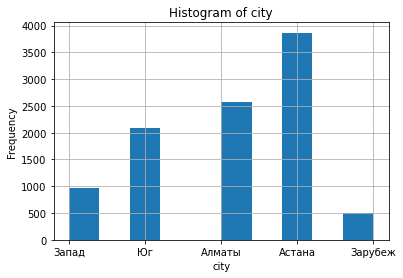

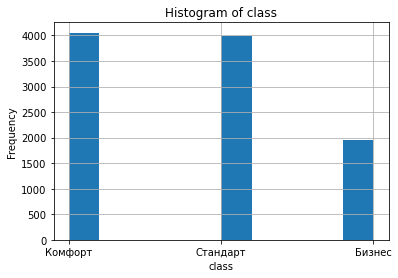

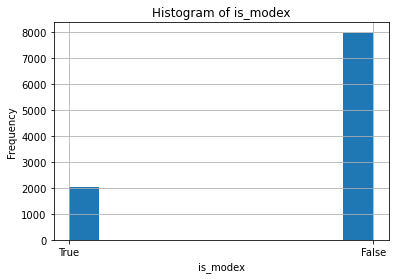

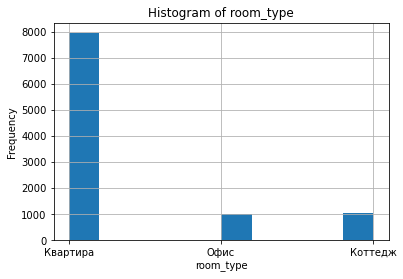

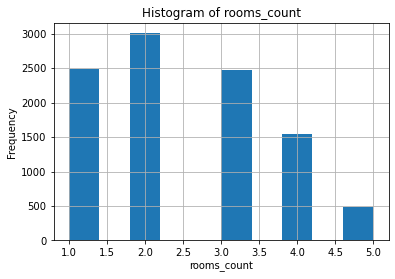

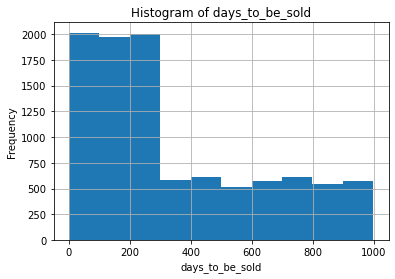

In [4]:
for col in historic_data.columns:
    plt.figure()  # Создаем новую фигуру
    historic_data[col].hist()
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Визуально проверили на реалистичность

Давайте проверим графики продаж по месяцам от 1-го до 18-го месяца, с учетом того, что  основные продажи реализуются в первой временной половине 

In [5]:
def show_the_sales_graph_accumilated(df):
    column_sums = df[df.columns.tolist()].sum()
    plt.figure(figsize=(10, 6))
    plt.bar(column_sums.index, column_sums.values)
    plt.xlabel('Кол-во месяцев')
    plt.ylabel('Продано объектов')
    plt.title('График продаж аккумулированный')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [19]:
historic_data

,city,class,is_modex,room_type,rooms_count,days_to_be_sold
0,Запад,Комфорт,True,Квартира,3,133
1,Юг,Стандарт,False,Квартира,1,499
2,Запад,Бизнес,False,Квартира,4,209
3,Алматы,Комфорт,True,Квартира,3,198
4,Астана,Комфорт,False,Квартира,5,314
...,...,...,...,...,...,...
9995,Юг,Комфорт,False,Квартира,1,63
9996,Астана,Комфорт,False,Квартира,2,292
9997,Алматы,Стандарт,False,Квартира,2,72
9998,Зарубеж,Бизнес,False,Квартира,2,939


In [20]:
for i in range(1,19):
    historic_data[f'sold after {i} monthes'] = (30*i> historic_data['days_to_be_sold']).astype(int)
    

In [38]:
historic_data.head()

,city,class,is_modex,room_type,rooms_count,days_to_be_sold,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,...,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
0,Запад,Комфорт,True,Квартира,3,133,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,Юг,Стандарт,False,Квартира,1,499,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,Запад,Бизнес,False,Квартира,4,209,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,Алматы,Комфорт,True,Квартира,3,198,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,Астана,Комфорт,False,Квартира,5,314,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1


In [46]:
columns_paramerets = historic_data.columns.tolist()[0:5]
columns_paramerets
for col in columns_paramerets:
    sales_by_classes = historic_data.groupby(col).agg({'sold after 6 monthes': lambda x:x.sum()/x.count(),'sold after 12 monthes': lambda x:x.sum()/x.count(),'sold after 18 monthes': lambda x:x.sum()/x.count()})
    sales_by_classes.reset_index(inplace=True)
    display(sales_by_classes)

,city,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,Алматы,0.346883,0.622145,0.730933
1,Астана,0.354705,0.627715,0.734488
2,Запад,0.362603,0.650826,0.744835
3,Зарубеж,0.369697,0.670707,0.769697
4,Юг,0.361457,0.633749,0.745446


,class,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,Бизнес,0.358790,0.645310,0.742696
1,Комфорт,0.358905,0.620868,0.729403
2,Стандарт,0.350688,0.636546,0.745932


,is_modex,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,False,0.357672,0.632794,0.739180
1,True,0.347462,0.628388,0.736323


,room_type,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,Квартира,0.358096,0.634475,0.741501
1,Коттедж,0.339048,0.623810,0.731429
2,Офис,0.353175,0.620040,0.723214


,rooms_count,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,1,0.359936,0.623942,0.739621
1,2,0.358949,0.636727,0.740519
2,3,0.345455,0.635152,0.738182
3,4,0.353588,0.627666,0.732385
4,5,0.370672,0.639511,0.743381


Так как в генераторе исходных данных я не задавал никаких долей или весов для параметров, у всех показывает равномерные показатели. На реальных данных можно будет на это взглянуть

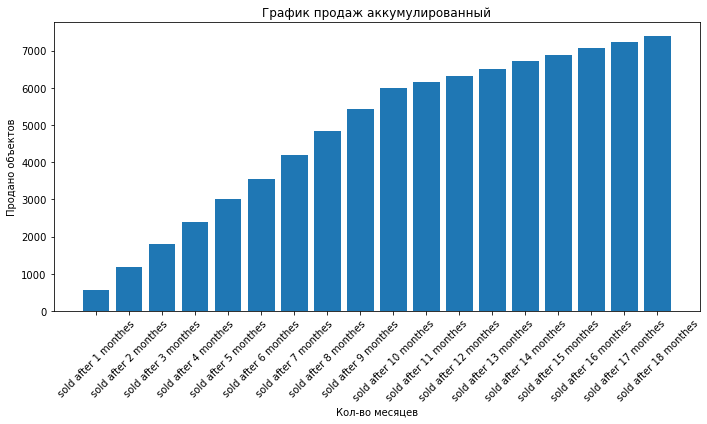

In [22]:
show_the_sales_graph_accumilated(historic_data[historic_data.columns.tolist()[6::]])

In [23]:
def show_the_sales_graph_by_month(df):
    sums = df.sum()
    differences = [sums[0]]+[sums[i + 1] - sums[i] for i in range(len(sums) - 1)]
    monthes=[i for i in range(1,19)]
    plt.figure(figsize=(10, 6))
    plt.bar(monthes, differences)
    plt.title('Продажи по каждому месяцу')
    plt.xlabel('Месяцы со старта продаж')
    plt.ylabel('Продано объектов')
    plt.show()

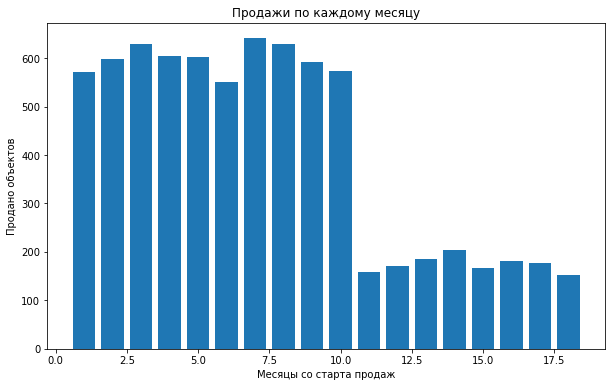

In [24]:
show_the_sales_graph_by_month(historic_data[historic_data.columns.tolist()[6::]])

Как видим, генератор правильно понял логику, что в основные продажи в первой части срока

Теперь сгенерируем параметры объектов, которые еще в проекте и попробуем предсказать на них графики продаж и сравним их и графиками исторических данных

In [25]:
columns = ['city', 'class', 'is_modex', 'room_type', 'rooms_count']
cities = ['Астана', 'Алматы', 'Юг', 'Запад','Зарубеж']
cities_probs = [0.4, 0.25, 0.2, 0.10,0.05]  # Вероятности для каждого города

classes = ['Стандарт', 'Комфорт', 'Бизнес']
classes_probs = [0.4, 0.4, 0.2]  # Вероятности для каждого класса жилья

is_modex = ['True','False']
is_modex_probs = [0.2,0.8]  # modex или нет

room_types = ['Квартира','Коттедж','Офис'] #тип недвижимости
room_type_probs = [0.8,0.1,0.1]

room_count = [1,2,3,4,5] #комнатность
room_count_probs = [0.25,0.3,0.25,0.15,0.05]

def get_random_values(n):
    return {
        'city': np.random.choice(cities, n, p=cities_probs),
        'class': np.random.choice(classes, n, p=classes_probs),
        'is_modex': np.random.choice(is_modex, n, p=is_modex_probs),
        'room_type': np.random.choice(room_types, n, p=room_type_probs),
        'rooms_count': np.random.choice(room_count, n, p=room_count_probs),
    }

num_rows = 1000

random_values = get_random_values(num_rows)
not_started = pd.DataFrame(random_values, columns=columns)
not_started

,city,class,is_modex,room_type,rooms_count
0,Алматы,Стандарт,False,Офис,2
1,Алматы,Стандарт,False,Квартира,4
2,Астана,Комфорт,False,Квартира,2
3,Зарубеж,Комфорт,False,Офис,2
4,Запад,Бизнес,False,Квартира,2
...,...,...,...,...,...
995,Астана,Комфорт,False,Офис,3
996,Астана,Стандарт,False,Квартира,4
997,Астана,Стандарт,False,Квартира,2
998,Астана,Комфорт,False,Квартира,3


Сгенерировали 1000 строк для квартир, старт продаж которых еще не начался

Натренируем на исторических данных и предскажем значения для 18 колонок, статусов продаж по месяцам

In [26]:
columnsX=historic_data.columns.tolist()[0:5]
columnsy=historic_data.columns.tolist()[6::]

In [27]:
X = historic_data[columnsX]
Y = historic_data[columnsy]
X = pd.get_dummies(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
linear_regressor = LinearRegression()
multi_target_regressor = MultiOutputRegressor(linear_regressor)
multi_target_regressor.fit(X_train, Y_train)

Y_test_pred = multi_target_regressor.predict(X_test)
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='uniform_average')
print(f"Mean Squared Error on test data: {test_mse}")

Y_train_pred = multi_target_regressor.predict(X_train)
train_mse = mean_squared_error(Y_train, Y_train_pred, multioutput='uniform_average')
print(f"Mean Squared Error on train data: {train_mse}")

Mean Squared Error on test data: 0.20428964738454672
Mean Squared Error on train data: 0.20175580880157132


mean squared error - 0.2 и почти одинаковый на тренировочных и тестовых данных. Значит модель не перетренирована.

с помощью модели предскажем статус проданности для 18 месяцев 

In [28]:
not_started = pd.get_dummies(not_started)
not_started_predictions = multi_target_regressor.predict(not_started)
not_started_predictions = pd.DataFrame(not_started_predictions, columns=columnsy)
not_started_predictions

,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,sold after 5 monthes,sold after 6 monthes,sold after 7 monthes,sold after 8 monthes,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
0,0.053406,0.111206,0.146851,0.225098,0.291016,0.349609,0.425781,0.476562,0.548828,0.595703,0.611328,0.630859,0.652344,0.667969,0.695312,0.708984,0.722656,0.742188
1,0.054565,0.105347,0.164673,0.235596,0.291260,0.346680,0.419922,0.484375,0.556641,0.609375,0.628906,0.646484,0.662109,0.683594,0.708984,0.726562,0.744141,0.751953
2,0.056396,0.125244,0.187744,0.242188,0.308594,0.364258,0.419922,0.480469,0.529297,0.583984,0.601562,0.619141,0.642578,0.658203,0.671875,0.691406,0.703125,0.720703
3,0.062805,0.148315,0.195068,0.272705,0.319824,0.381836,0.452148,0.527344,0.589844,0.644531,0.652344,0.667969,0.689453,0.705078,0.714844,0.730469,0.751953,0.765625
4,0.072144,0.124756,0.202393,0.248779,0.309082,0.365723,0.433594,0.521484,0.580078,0.625000,0.642578,0.669922,0.681641,0.685547,0.701172,0.716797,0.734375,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.055054,0.115723,0.159302,0.216797,0.292480,0.354004,0.414551,0.472656,0.515625,0.564453,0.582031,0.601562,0.625000,0.632812,0.646484,0.666016,0.681641,0.703125
996,0.056824,0.110352,0.168091,0.223633,0.288818,0.347168,0.411133,0.470703,0.535156,0.589844,0.611328,0.630859,0.652344,0.664062,0.683594,0.703125,0.716797,0.728516
997,0.056946,0.120728,0.175049,0.233643,0.299316,0.355957,0.418945,0.470703,0.537109,0.593750,0.613281,0.630859,0.658203,0.671875,0.691406,0.707031,0.718750,0.734375
998,0.056335,0.120117,0.184204,0.237305,0.303223,0.359863,0.416016,0.480469,0.527344,0.583984,0.599609,0.619141,0.640625,0.654297,0.669922,0.689453,0.703125,0.718750


Визуализируем аккумулированный и месячный графики продаж

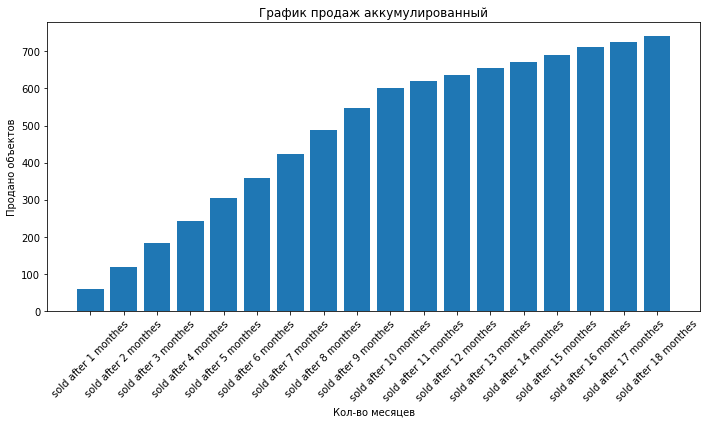

In [29]:
show_the_sales_graph_accumilated(not_started_predictions)

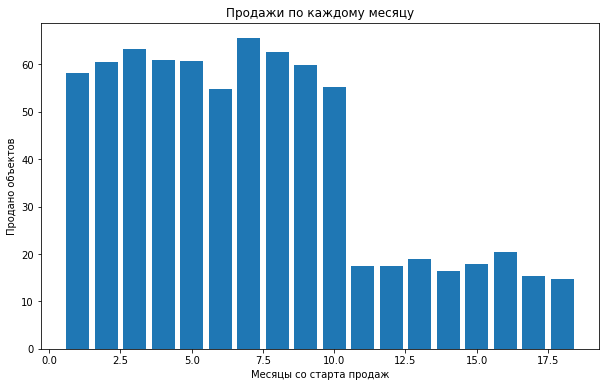

In [30]:
show_the_sales_graph_by_month(not_started_predictions)

Графики очень похожи на графики исторических данных

Вторая часть задачи. 
- Есть жк комфорт класса, со старта продаж прошло 8 месяцев и есть данные и продажах
- Построим план продаж оставшихся 10 месяцев на основе 8 месяцев этого жк и исторических данных.
- Предположим, что прошел еще месяц и есть новые данные, тогда добавим его в факт и  скорректируем план продаж на оставшиеся 9 месяцев

Идея состоит в том,чтобы вывести проценты продаваемости индивидально для каждой группы объектов по набору типов город-класс-модекс/нет-тип недвижимости-кол-во  комнат.

In [53]:
result = historic_data.groupby(['city', 'class', 'is_modex', 'room_type', 'rooms_count']).agg({
    'sold after 1 monthes': lambda x:x.sum()/x.count(),
    'sold after 2 monthes': lambda x:x.sum()/x.count(),
    'sold after 3 monthes': lambda x:x.sum()/x.count(),
    'sold after 4 monthes': lambda x:x.sum()/x.count(),
    'sold after 5 monthes': lambda x:x.sum()/x.count(),
    'sold after 6 monthes': lambda x:x.sum()/x.count(),
    'sold after 7 monthes': lambda x:x.sum()/x.count(),
    'sold after 8 monthes': lambda x:x.sum()/x.count(),
    'sold after 9 monthes': lambda x:x.sum()/x.count(),
    'sold after 10 monthes': lambda x:x.sum()/x.count(),
    'sold after 11 monthes': lambda x:x.sum()/x.count(),
    'sold after 12 monthes': lambda x:x.sum()/x.count(),
    'sold after 13 monthes': lambda x:x.sum()/x.count(),
    'sold after 14 monthes': lambda x:x.sum()/x.count(),
    'sold after 15 monthes': lambda x:x.sum()/x.count(),
    'sold after 16 monthes': lambda x:x.sum()/x.count(),
    'sold after 17 monthes': lambda x:x.sum()/x.count(),
    'sold after 18 monthes': lambda x:x.sum()/x.count()
    }).reset_index()

In [102]:
result[(result['city']=='Астана')&(result['class']=='Комфорт')].head()

,city,class,is_modex,room_type,rooms_count,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,sold after 5 monthes,...,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
114,Астана,Комфорт,False,Квартира,1,0.076271,0.144068,0.203390,0.245763,0.300847,...,0.512712,0.563559,0.572034,0.584746,0.614407,0.635593,0.656780,0.669492,0.669492,0.711864
115,Астана,Комфорт,False,Квартира,2,0.060498,0.138790,0.195730,0.241993,0.302491,...,0.537367,0.587189,0.615658,0.626335,0.651246,0.654804,0.661922,0.683274,0.693950,0.704626
116,Астана,Комфорт,False,Квартира,3,0.033835,0.086466,0.165414,0.225564,0.293233,...,0.545113,0.601504,0.612782,0.627820,0.642857,0.665414,0.669173,0.680451,0.695489,0.718045
117,Астана,Комфорт,False,Квартира,4,0.076923,0.128205,0.173077,0.217949,0.307692,...,0.525641,0.576923,0.596154,0.615385,0.634615,0.653846,0.673077,0.679487,0.698718,0.705128
118,Астана,Комфорт,False,Квартира,5,0.050000,0.100000,0.125000,0.175000,0.200000,...,0.475000,0.575000,0.600000,0.650000,0.650000,0.675000,0.700000,0.700000,0.725000,0.725000


In [64]:
columns_1_to_18 = result.columns.tolist()[5::]

In [62]:
result['sold after 1 monthes'].mean()

0.06350442860566198

In [101]:
historic_sales_rate_list = [result[col].mean() for col in columns_1_to_18]
historic_sales_rate = pd.DataFrame([historic_sales_rate_list], columns=columns_1_to_18)
historic_sales_rate

,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,sold after 5 monthes,sold after 6 monthes,sold after 7 monthes,sold after 8 monthes,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
0,0.063504,0.118278,0.172728,0.235103,0.285847,0.353401,0.419303,0.481589,0.545226,0.604125,0.618262,0.633755,0.648568,0.66793,0.680276,0.699001,0.725465,0.741446


Так как в сгенерированных тестовых данных все планы по всем видам разбиений по типам ровномеры, в конретной задаче решил взять единый график коэффициентов продаваемости по месяцам

Моделирум ситуацию ЖК "take_home",  с разным количеством разнокомнатных квартир, и с каким-то количеством проданных.

In [98]:
data = {
    'Количество квартир': ['1-комн', '2-комн', '3-комн', '4-комн', '5-комн'],
    'Количество квартир':[150,170,100,50,30],
    'Продано за 8 месяцев, факт': [65,84,35,15,12],
    'Продано за 8 месяцев, план': [np.nan] * 5
}
take_home = pd.DataFrame(data)
take_home['Продано за 8 месяцев, план'] = take_home['Количество квартир']*0.481589

take_home

,Количество квартир,"Продано за 8 месяцев, факт","Продано за 8 месяцев, план"
0,150,65,72.23835
1,170,84,81.87013
2,100,35,48.15890
3,50,15,24.07945
4,30,12,14.44767


Посчитаем отставание от плана по каждому типу

In [99]:
take_home['Отставание'] = take_home['Продано за 8 месяцев, план'] - take_home['Продано за 8 месяцев, факт']
take_home['Отставание'] = take_home['Отставание'].apply(lambda x: max(x, 0))
take_home

,Количество квартир,"Продано за 8 месяцев, факт","Продано за 8 месяцев, план",Отставание
0,150,65,72.23835,7.23835
1,170,84,81.87013,0.00000
2,100,35,48.15890,13.15890
3,50,15,24.07945,9.07945
4,30,12,14.44767,2.44767


Как видно, по четырем из пяти квартир есть отставания от планов продаж от исторического графика. Идея состоит в том, чтобы распределить эти отставания равномерно на осташеися 10 месяцев и получить новый план продаж

In [100]:
historic_sales_rate_from_9 = historic_sales_rate[historic_sales_rate.columns.tolist()[8::]]
coefficients = historic_sales_rate_from_9.iloc[0].tolist()
for i in range(9,19):
    take_home[f'План продаж за {i} месяцев'] = take_home['Количество квартир']*coefficients[i-9]+take_home['Отставание']/10
take_home

,Количество квартир,"Продано за 8 месяцев, факт","Продано за 8 месяцев, план",Отставание,План продаж за 9 месяцев,План продаж за 10 месяцев,План продаж за 11 месяцев,План продаж за 12 месяцев,План продаж за 13 месяцев,План продаж за 14 месяцев,План продаж за 15 месяцев,План продаж за 16 месяцев,План продаж за 17 месяцев,План продаж за 18 месяцев
0,150,65,72.23835,7.23835,82.507774,91.342513,93.463180,95.787064,98.009090,100.913300,102.765280,105.573948,109.543642,111.940778
1,170,84,81.87013,0.00000,92.688464,102.701168,105.104591,107.738326,110.256623,113.548060,115.646971,118.830129,123.329114,126.045868
2,100,35,48.15890,13.15890,55.838516,61.728342,63.142120,64.691376,66.172727,68.108866,69.343520,71.215966,73.862428,75.460518
3,50,15,24.07945,9.07945,28.169258,31.114171,31.821060,32.595688,33.336363,34.304433,34.921760,35.857983,37.181214,37.980259
4,30,12,14.44767,2.44767,16.601555,18.368503,18.792636,19.257413,19.701818,20.282660,20.653056,21.214790,22.008728,22.488156
